
<div class="alert alert-block alert-info"><font size="5"><center><b><u> S12 T01: Aprenentatge Supervisat - Regressions
   </u></b></center></font>
\begin{align*}Marc\:Breysse\end{align*}</div>

<span style=color:blue>*Anem a practicar i a familiaritzar-nos amb regressions.*</span>

# <span style=color:darkblue>Nivell 1</span>

<u style=color:blue>Exercici 1:</u>

<span style=color:blue>Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv</span>

In [1]:
import os
import pandas as pd
import numpy as np
import datetime 
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import researchpy as rp
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split

from statsmodels.formula.api import ols
    
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Dataset saved in Sprint11
DF = pd.read_csv('DelayedFlightsCleaned.csv')
DF.shape

(1928371, 14)

In [3]:
# to reduce cumputation time, we will reduce dataset to 10.000 samples
DF = DF.sample(n=10000, random_state=1)
DF.shape

(10000, 14)

In [4]:
DF.head()

,Unnamed: 0,DayOfWeek,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,UniqueCarrier,Origin,Dest,Date
942808,946177,6,642,734,96.0,92.0,43.0,39.0,6.0,17.0,OO,TUS,LAX,2008-06-07
1484347,1490024,1,1115,1185,62.0,70.0,1.0,9.0,6.0,6.0,MQ,MAF,DFW,2008-09-22
1566787,1572676,6,975,1037,112.0,122.0,-1.0,9.0,7.0,14.0,US,CLT,ORD,2008-10-18
1256237,1261096,2,1040,1160,149.0,120.0,57.0,28.0,5.0,59.0,DL,ATL,DCA,2008-07-08
651063,653536,5,1000,1037,92.0,97.0,8.0,13.0,7.0,8.0,EV,CVG,MEM,2008-04-04


In [5]:
DF.nunique()

Unnamed: 0           10000
DayOfWeek                7
CRSDepTime             917
CRSArrTime            1130
ActualElapsedTime      401
CRSElapsedTime         374
ArrDelay               367
DepDelay               321
TaxiIn                  58
TaxiOut                133
UniqueCarrier           20
Origin                 250
Dest                   260
Date                   366
dtype: int64

In [6]:
# We will start to predict Arrival Delay based basically on 'CRS Departure Time', 'CRS Arrival Time' and 'Departure Delay'.
# Also, to reduce scope of this study, we will not consider airports and date.
DF.drop(['Date','Origin','Dest','Unnamed: 0','CRSElapsedTime','ActualElapsedTime'], axis='columns', inplace=True)

In [7]:
DF.columns

Index(['DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'ArrDelay', 'DepDelay',
       'TaxiIn', 'TaxiOut', 'UniqueCarrier'],
      dtype='object')

<span style=color:green>Data correlation</span>

In [8]:
DF.corr().round(3)

,DayOfWeek,CRSDepTime,CRSArrTime,ArrDelay,DepDelay,TaxiIn,TaxiOut
DayOfWeek,1.000,0.018,0.008,0.004,0.008,-0.022,-0.001
CRSDepTime,0.018,1.000,0.674,0.026,0.041,-0.053,0.021
CRSArrTime,0.008,0.674,1.000,0.028,0.035,-0.007,0.050
ArrDelay,0.004,0.026,0.028,1.000,0.954,0.164,0.313
DepDelay,0.008,0.041,0.035,0.954,1.000,0.087,0.106
TaxiIn,-0.022,-0.053,-0.007,0.164,0.087,1.000,0.059
TaxiOut,-0.001,0.021,0.050,0.313,0.106,0.059,1.000


<span style=color:green>*'ArrDelay' is obviously correlated with 'DepDelay' & to some extent to other numerical variables like 'TaxiOut','TaxiIn'*</span>

<span style=color:green>Statistical infos on Departure Delay of each airline</span>

In [9]:
# Extract statistical parameters with grouby 'Carrier':
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

UniqueCarrier_delay_stats = DF['DepDelay'].groupby(DF['UniqueCarrier']).apply(get_stats).unstack()
UniqueCarrier_delay_stats = UniqueCarrier_delay_stats.sort_values('count')
UniqueCarrier_delay_stats

,min,max,count,mean
UniqueCarrier,,,,
AQ,8.0,60.0,3.0,31.000000
HA,6.0,435.0,50.0,33.360000
F9,6.0,356.0,143.0,29.433566
AS,6.0,386.0,196.0,40.076531
OH,6.0,310.0,269.0,45.862454
9E,6.0,401.0,276.0,49.485507
B6,6.0,416.0,314.0,52.742038
YV,6.0,415.0,325.0,49.184615
FL,6.0,291.0,363.0,43.168044


<AxesSubplot:title={'center':'Mean'}, ylabel='mean'>

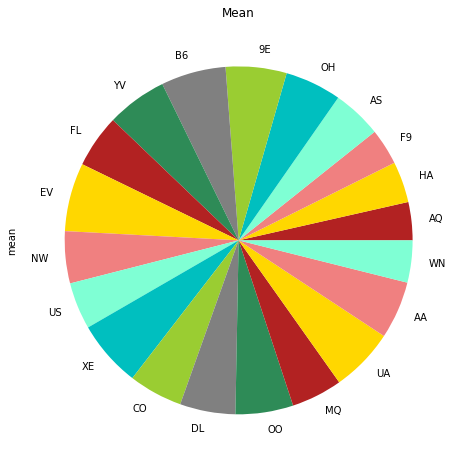

In [10]:
fig=plt.figure(figsize=(8,8))
UniqueCarrier_delay_stats['mean'].plot.pie(title = 'Mean', colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen'])

<span style=color:green><b>REGRESSION MODEL PREPARATION</span>

In [11]:
DF.columns

Index(['DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'ArrDelay', 'DepDelay',
       'TaxiIn', 'TaxiOut', 'UniqueCarrier'],
      dtype='object')

<span style=color:green>4.1 Definition of dependent and independent variables</span>

<span style=color:green>*y = ArrDelay*</span>

<span style=color:green>*X = All variables apart from ArrDelay*</span>

In [12]:
X, y = DF.drop('ArrDelay',axis=1), DF.ArrDelay
print(X.shape, y.shape)

(10000, 7) (10000,)


In [13]:
X.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier
942808,6,642,734,39.0,6.0,17.0,OO
1484347,1,1115,1185,9.0,6.0,6.0,MQ
1566787,6,975,1037,9.0,7.0,14.0,US
1256237,2,1040,1160,28.0,5.0,59.0,DL
651063,5,1000,1037,13.0,7.0,8.0,EV


<span style=color:green>Split the dataset into train and test subsets</span>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 7), (2000, 7), (8000,), (2000,))

<span style=color:green>'Unique Carrier'Encoding</span>

In [16]:
# Apply dummy to X_train

# Create dummy variables
dummy_UniqueCarrier_type = pd.get_dummies(X_train['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)

# Drop unnecessary columns
to_drop = ['UniqueCarrier']
X_train.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
X_train = pd.concat([X_train, dummy_UniqueCarrier_type], axis=1)
X_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
758739,3,510,595,11.0,4.0,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1059361,3,1085,1263,215.0,16.0,14.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
367781,1,1070,1223,11.0,10.0,17.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
957591,7,935,1294,17.0,5.0,11.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1771991,1,755,882,213.0,5.0,24.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
# Apply dummy to X_test
dummy_UniqueCarrier_type = pd.get_dummies(X_test['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)
to_drop = ['UniqueCarrier']
X_test.drop(to_drop, axis=1, inplace=True)
# Merge into a single data frame
X_test = pd.concat([X_test, dummy_UniqueCarrier_type], axis=1)
X_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1205104,5,1035,1235,153.0,3.0,13.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
615091,7,1148,1248,22.0,5.0,27.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1317914,4,741,782,44.0,5.0,15.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1737109,1,1240,1425,51.0,4.0,17.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
903835,6,840,1005,88.0,6.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<span style=color:green>Standardize numerical variables</span>

In [18]:
from sklearn.preprocessing import StandardScaler

# Scale selected columns by index
# Set up scaler
scaler = StandardScaler().fit(X_train.iloc[:,:6])
X_train.iloc[:,:6] = scaler.transform(X_train.iloc[:,:6])
X_train.head()
#  Scale X_Test data
X_test.iloc[:,:6] = scaler.transform(X_test.iloc[:,:6])

In [19]:
X_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
758739,-0.48302,-1.488084,-1.371033,-0.603823,-0.576158,-0.440820,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1059361,-0.48302,0.752146,0.966001,3.106778,1.913542,-0.306934,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
367781,-1.48164,0.693705,0.826059,-0.603823,0.668692,-0.106105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
957591,1.51422,0.167738,1.074456,-0.494688,-0.368683,-0.507764,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1771991,-1.48164,-0.533552,-0.366948,3.070400,-0.368683,0.362497,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
X_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1205104,0.51560,0.557343,0.868042,1.979047,-0.783633,-0.373877,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
615091,1.51422,0.997597,0.913523,-0.403742,-0.368683,0.563326,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1317914,0.01629,-0.588096,-0.716804,-0.003579,-0.368683,-0.239991,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1737109,-1.48164,1.356034,1.532767,0.123746,-0.576158,-0.106105,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
903835,1.01491,-0.202387,0.063374,0.796747,-0.161208,-0.507764,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<span style=color:green><b>REGRESSION MODELS

<span style=color:green><b>MLR - MULTIPLE LINEAR REGRESSION</span>

In [21]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
model_mlr = regressor.fit(X_train, y_train)

<span style=color:green>R-squared</span>

In [22]:
model_mlr.score(X_test, y_test)

0.9583286174052228

<span style=color:green>Predictions</span>

In [23]:
y_pred_mlr = model_mlr.predict(X_test)

In [24]:
df_y_pred_mlr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_mlr})
df_y_pred_mlr

,Actual,Predicted
1205104,152.0,144.492173
615091,27.0,22.076694
1317914,39.0,42.053562
1737109,49.0,49.817190
903835,87.0,84.017259
...,...,...
1250965,147.0,138.159779
1051615,95.0,91.079161
1728299,75.0,86.004859
282001,-1.0,3.904786


<span style=color:green>Evaluating Algorithm</span>

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_mlr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_mlr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr)))

Mean Absolute Error: 8.011397134517312
Mean Squared Error: 125.09090621062519
Root Mean Squared Error: 11.18440459794911


<span style=color:green><b>RANDOM FOREST </span>

In [26]:
from sklearn.ensemble import RandomForestRegressor

# model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf = rf.fit(X_train, y_train)

<span style=color:green>R-squared</span>

In [27]:
model_rf.score(X_test, y_test)

0.9480335153799598

<span style=color:green>Coefficients for all the attributes</span>

In [28]:
model_rf.feature_importances_

array([3.05722874e-03, 7.66769136e-03, 7.07107621e-03, 9.10401973e-01,
       8.32845873e-03, 5.39150081e-02, 7.25283130e-04, 4.85308033e-06,
       1.94388990e-04, 6.01725618e-04, 1.28365865e-03, 5.62995598e-04,
       3.81294105e-04, 1.16394936e-04, 3.29166498e-04, 2.43563317e-04,
       4.36897322e-04, 8.69574509e-04, 6.60682683e-04, 4.13311556e-04,
       7.39059565e-04, 5.62003287e-04, 6.02244190e-04, 6.10994506e-04,
       2.20472769e-04])

<span style=color:green>Predictions</span>

In [29]:
y_pred_rf = model_rf.predict(X_test)

In [30]:
df_y_pred_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
df_y_pred_rf

,Actual,Predicted
1205104,152.0,147.855
615091,27.0,19.825
1317914,39.0,40.730
1737109,49.0,48.175
903835,87.0,79.205
...,...,...
1250965,147.0,145.595
1051615,95.0,89.965
1728299,75.0,80.220
282001,-1.0,8.900


<span style=color:green>Evaluating Algorithm</span>

In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 8.599884999999999
Mean Squared Error: 155.99517580000003
Root Mean Squared Error: 12.48980287274383


<span style=color:green><b>XGBOOST </span>

In [32]:
import xgboost as xg
from sklearn.metrics import mean_squared_error

xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
model_xgb = xgb_r.fit(X_train, y_train)

[18:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


<span style=color:green>R-squared</span>

In [33]:
model_xgb.score(X_test, y_test)

0.9462634229440969

<span style=color:green>Coefficients for all the attributes</span>

In [34]:
model_xgb.feature_importances_

array([1.2507229e-03, 3.0304957e-03, 3.1506997e-03, 9.0982699e-01,
       8.5160062e-03, 4.0973555e-02, 0.0000000e+00, 0.0000000e+00,
       5.7797291e-04, 4.0081851e-03, 4.5425296e-03, 3.9479220e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.3344522e-03,
       0.0000000e+00, 0.0000000e+00, 3.0737282e-03, 4.3621510e-03,
       2.0077038e-03, 2.4025415e-03, 3.1038462e-03, 1.8904796e-03,
       0.0000000e+00], dtype=float32)

<span style=color:green>Predictions</span>

In [35]:
y_pred_xgb = model_xgb.predict(X_test)

In [36]:
df_y_pred_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb})
df_y_pred_xgb

,Actual,Predicted
1205104,152.0,143.346893
615091,27.0,24.781116
1317914,39.0,38.285057
1737109,49.0,46.764645
903835,87.0,79.577415
...,...,...
1250965,147.0,141.312714
1051615,95.0,83.031395
1728299,75.0,80.855629
282001,-1.0,5.365035


<span style=color:green>Evaluating Algorithm</span>

In [37]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))

Mean Absolute Error: 8.653206110909581
Mean Squared Error: 161.3087136067925
Root Mean Squared Error: 12.700736734803714


<u style=color:blue>Exercici 2:</u>

<span style=color:blue>Compara’ls en base al MSE i al R2 .</span>

<span style=color:green><b>R-squared value is: </span>        

In [38]:
print('1.Multiple linear regression ', model_mlr.score(X_test, y_test).round(5))
print('2.Random forest regression', model_rf.score(X_test, y_test).round(5))
print('3.Xgboost regression', model_xgb.score(X_test, y_test).round(5))

1.Multiple linear regression  0.95833
2.Random forest regression 0.94803
3.Xgboost regression 0.94626


<span style=color:green><b>MSE Mean Squared Error  </span>     

In [39]:
print('1.Multiple linear regression ', metrics.mean_squared_error(y_test, y_pred_mlr).round(1))
print('2.Random forest regression', metrics.mean_squared_error(y_test, y_pred_rf).round(1))
print('3.Xgboost regression', metrics.mean_squared_error(y_test, y_pred_xgb).round(1))

1.Multiple linear regression  125.1
2.Random forest regression 156.0
3.Xgboost regression 161.3


<span style=color:green>*The multiple linear regression seems to give the best results*</span>

<u style=color:blue>Exercici 3:</u>

<span style=color:blue>Entrena’ls utilitzant els diferents paràmetres que admeten.</span>

<span style=color:green><b>RANDOM FOREST tuning</span>     

In [40]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use in rf model:\n')
pprint(rf.get_params())

Parameters currently in use in rf model:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [41]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [43]:
from sklearn.model_selection import GridSearchCV

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, random_state=42),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [44]:
CV_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500}

In [45]:
rf1 = RandomForestRegressor(random_state=42, max_features='auto', n_estimators= 500)
model_rf1 = rf1.fit(X_train, y_train)

In [53]:
print('Random forest regression_CV', model_rf1.score(X_test, y_test).round(5))

Random forest regression_CV 0.94835


<span style=color:green>*R2 has improved very slightly from 0.94803 to 0.94835*</span>

<span style=color:green>*with additional parameters and computation, we can certainly improve again R2*</span>

#### <span style=color:green>XGBOOST tuning </span>

In [81]:
pprint(xgb_r.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 10,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'objective': 'reg:linear',
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 123,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


In [82]:
param_grid = { 
    'n_estimators': [5,10,20,50,100],
    'max_depth': [5, 6, 7],
}

In [83]:
CV_xgb_r = GridSearchCV(estimator=xgb_r, param_grid=param_grid, cv= 5)
CV_xgb_r.fit(X_train, y_train)

[14:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

[14:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=10, n_jobs=4,
                                    num_parallel_tree=1, objective='reg:linear',
                                    random_state=123, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=123, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                        

In [75]:
CV_xgb_r.best_params_

{'max_depth': 5, 'n_estimators': 50}

In [78]:
xgb_r1 = xg.XGBRegressor(random_state=42, max_depth=5, n_estimators= 50)
model_xgb_r1 = xgb_r1.fit(X_train, y_train)

In [80]:
print('XGboost regression_CV', model_xgb_r1.score(X_test, y_test).round(5))

XGboost regression_CV 0.95421


<span style=color:green>*R2 has improved from 0.946 to 0.954*</span>

<u style=color:blue>Exercici 4:</u>

<span style=color:blue>Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)</span>

<span style=color:green>Let's compare results of multiple linear regression between datasets of 10000 sampled rows and 1.9M rows</span>

DF_All = 1.9M rows

In [84]:
DF_All = pd.read_csv('DelayedFlightsCleaned.csv')
DF_All.shape

(1928371, 14)

In [85]:
DF_All.drop(['Date','Origin','Dest','Unnamed: 0','CRSElapsedTime','ActualElapsedTime'], axis='columns', inplace=True)

In [86]:
X_All, y_All = DF_All.drop('ArrDelay',axis=1), DF_All.ArrDelay
print(X.shape, y.shape)

(10000, 7) (10000,)


In [87]:
X_All.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier
0,4,1195,1345,8.0,4.0,8.0,WN
1,4,455,600,19.0,5.0,10.0,WN
2,4,380,470,8.0,3.0,17.0,WN
3,4,1075,1165,34.0,3.0,10.0,WN
4,4,1155,1270,25.0,4.0,10.0,WN


In [88]:
X_All_train, X_All_test, y_All_train, y_All_test = train_test_split(X_All, y_All, test_size=0.2, random_state=0)

In [89]:
X_All_train.shape, X_All_test.shape, y_All_train.shape, y_All_test.shape

((1542696, 7), (385675, 7), (1542696,), (385675,))

In [90]:
# Apply dummy to X_train

# Create dummy variables
dummy_UniqueCarrier_type = pd.get_dummies(X_All_train['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)

# Drop unnecessary columns
to_drop = ['UniqueCarrier']
X_All_train.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
X_All_train = pd.concat([X_All_train, dummy_UniqueCarrier_type], axis=1)
X_All_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
526492,6,890,1355,21.0,8.0,10.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319418,4,1150,1305,26.0,12.0,51.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
603985,7,925,1029,38.0,23.0,14.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1490960,4,900,1020,99.0,3.0,20.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
451136,6,413,595,6.0,3.0,26.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [91]:
# Apply dummy to X_test
dummy_UniqueCarrier_type = pd.get_dummies(X_All_test['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)
to_drop = ['UniqueCarrier']
X_All_test.drop(to_drop, axis=1, inplace=True)
# Merge into a single data frame
X_All_test = pd.concat([X_All_test, dummy_UniqueCarrier_type], axis=1)
X_All_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1824985,1,955,1015,94.0,2.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
184235,7,640,770,18.0,5.0,7.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
278041,6,1155,1210,8.0,4.0,10.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1544038,4,1125,1313,35.0,5.0,18.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
540657,2,1090,1305,66.0,5.0,12.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
from sklearn.preprocessing import StandardScaler

# Scale selected columns by index
# Set up scaler
scaler = StandardScaler().fit(X_All_train.iloc[:,:6])
X_All_train.iloc[:,:6] = scaler.transform(X_All_train.iloc[:,:6])
X_All_train.head()
#  Scale X_Test data
X_All_test.iloc[:,:6] = scaler.transform(X_All_test.iloc[:,:6])

In [93]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
model_mlr_All = regressor.fit(X_All_train, y_All_train)

<span style=color:green>R-squared</span>

In [94]:
model_mlr_All.score(X_All_test, y_All_test).round(3)

0.962

<span style=color:green>*As expected R-squared of 0.962 for dataset 1.9M rows > R-squared 0.958 of dataset 10.000 rows*</span>

<span style=color:green>Predictions</span>

In [95]:
y_All_pred_mlr = model_mlr_All.predict(X_All_test)

In [96]:
df_y_All_pred_mlr = pd.DataFrame({'Actual': y_All_test, 'Predicted': y_All_pred_mlr})
df_y_All_pred_mlr

,Actual,Predicted
1824985,84.0,83.858411
184235,7.0,10.678743
278041,1.0,1.002867
1544038,31.0,29.861643
540657,62.0,56.506962
...,...,...
1543725,34.0,24.304840
292873,40.0,30.148702
448721,180.0,183.067516
1736103,18.0,24.370338


<span style=color:green>Evaluating Algorithm</span>

In [97]:
print('Mean Squared Error:', metrics.mean_squared_error(y_All_test, y_All_pred_mlr))

Mean Squared Error: 122.09492927163645


<span style=color:green>*As expected MSE of 122.09 for dataset 1.9M rows < MSE of 154.92 of dataset 10.000 rows*</span>

<span style=color:green>*Predictions are better while increasing number of rows from 10.000 to 1.9M*</span>

# <span style=color:darkblue>Nivell 2</span>

<u style=color:blue>Exercici 5:</u>

<span style=color:blue>Realitza algun procés d’enginyeria de variables per millorar-ne la predicció.<span>

<span style=color:green>From starting point, feature engineering has been applied to create dummy from 'UniqueCarrier'. Now let's compare results without 'UniqueCarrier' feature engineering with Multiple linear regression</span>

In [98]:
DF.columns

Index(['DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'ArrDelay', 'DepDelay',
       'TaxiIn', 'TaxiOut', 'UniqueCarrier'],
      dtype='object')

<span style=color:green>Let's drop 'UniqueCarrier'</span>

<span style=color:green>*y = ArrDelay*</span>

<span style=color:green>*X = All variables apart from ArrDelay & UniqueCarrier*</span>

In [99]:
X, y = DF.drop(['ArrDelay','UniqueCarrier'],axis=1), DF.ArrDelay
print(X.shape, y.shape)

(10000, 6) (10000,)


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [101]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

In [102]:
X_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut
758739,3,510,595,11.0,4.0,12.0
1059361,3,1085,1263,215.0,16.0,14.0
367781,1,1070,1223,11.0,10.0,17.0
957591,7,935,1294,17.0,5.0,11.0
1771991,1,755,882,213.0,5.0,24.0


In [103]:
X_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,DepDelay,TaxiIn,TaxiOut
1205104,5,1035,1235,153.0,3.0,13.0
615091,7,1148,1248,22.0,5.0,27.0
1317914,4,741,782,44.0,5.0,15.0
1737109,1,1240,1425,51.0,4.0,17.0
903835,6,840,1005,88.0,6.0,11.0


In [104]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [105]:
print(X_train)

[[-0.48302015 -1.48808443 -1.37103327 -0.60382309 -0.57615818 -0.4408204 ]
 [-0.48302015  0.75214552  0.96600123  3.10677841  1.91354227 -0.30693418]
 [-1.48164043  0.69370474  0.82605904 -0.60382309  0.66869205 -0.10610484]
 ...
 [-1.48164043  0.01189562  0.01089581  2.96126463  0.87616708 -0.4408204 ]
 [-0.48302015  0.53786265  0.66862408 -0.54925542  0.46121701  0.16166762]
 [ 1.51422042  0.9079876   0.8365547  -0.22184941 -0.78363322  0.49638319]]


In [106]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
model_mlr = regressor.fit(X_train, y_train)

<span style=color:green>R-squared</span>

In [107]:
model_mlr.score(X_test, y_test)

0.9552698304430816

In [108]:
y_pred_mlr = model_mlr.predict(X_test)

In [109]:
df_y_pred_mlr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_mlr})
df_y_pred_mlr

,Actual,Predicted
1205104,152.0,142.951243
615091,27.0,25.942099
1317914,39.0,39.601383
1737109,49.0,45.395029
903835,87.0,79.744174
...,...,...
1250965,147.0,146.262436
1051615,95.0,90.555394
1728299,75.0,81.944495
282001,-1.0,8.277860


In [110]:

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_mlr))


Mean Squared Error: 134.2729013635157


<span style=color:green>*R-squared of 0.958 with variable 'UniqueCarrier' > R-squared of 0.955 without variable 'UniqueCarrier'*</span>

<span style=color:green>*MSE of 125.09 with variable 'UniqueCarrier' < MSE of 134.27 without variable 'UniqueCarrier'*</span>

<span style=color:green>*Predictions are slightly improved with feature enginnering on 'UniqueCarrier'*</span>

# <span style=color:darkblue>Nivell 3</span>

<u style=color:blue>Exercici 6:</u>

<span style=color:blue>No utilitzis la variable DepDelay a l’hora de fer prediccions.<span>

<span style=color:green>Let's check impact impact on multiple linear regression from Exercici 1 from Nivell 1</span>

In [111]:
# Definition of dependent and independent variables
X, y = DF.drop(['DepDelay','ArrDelay'],axis=1), DF.ArrDelay
print(X.shape, y.shape)

(10000, 6) (10000,)


In [112]:
X.head()

,DayOfWeek,CRSDepTime,CRSArrTime,TaxiIn,TaxiOut,UniqueCarrier
942808,6,642,734,6.0,17.0,OO
1484347,1,1115,1185,6.0,6.0,MQ
1566787,6,975,1037,7.0,14.0,US
1256237,2,1040,1160,5.0,59.0,DL
651063,5,1000,1037,7.0,8.0,EV


In [113]:
# Split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [114]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

In [115]:
# 'Unique Carrier': Create dummy

# Create dummy variables
dummy_UniqueCarrier_type = pd.get_dummies(X_train['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)

# Drop unnecessary columns
to_drop = ['UniqueCarrier']
X_train.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
X_train = pd.concat([X_train, dummy_UniqueCarrier_type], axis=1)
X_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
758739,3,510,595,4.0,12.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1059361,3,1085,1263,16.0,14.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
367781,1,1070,1223,10.0,17.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
957591,7,935,1294,5.0,11.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1771991,1,755,882,5.0,24.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [116]:
# Apply dummy to X_test
dummy_UniqueCarrier_type = pd.get_dummies(X_test['UniqueCarrier'], prefix='UniqueCarrier', drop_first=True)
to_drop = ['UniqueCarrier']
X_test.drop(to_drop, axis=1, inplace=True)
# Merge into a single data frame
X_test = pd.concat([X_test, dummy_UniqueCarrier_type], axis=1)
X_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1205104,5,1035,1235,3.0,13.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
615091,7,1148,1248,5.0,27.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1317914,4,741,782,5.0,15.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1737109,1,1240,1425,4.0,17.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
903835,6,840,1005,6.0,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [117]:
# Standardize variables

from sklearn.preprocessing import StandardScaler

# Scale selected columns by index
# Set up scaler
scaler = StandardScaler().fit(X_train.iloc[:,:5])
X_train.iloc[:,:5] = scaler.transform(X_train.iloc[:,:5])
X_train.head()
#  Scale X_Test data
X_test.iloc[:,:5] = scaler.transform(X_test.iloc[:,:5])

In [118]:
X_train.head()

,DayOfWeek,CRSDepTime,CRSArrTime,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
758739,-0.48302,-1.488084,-1.371033,-0.576158,-0.440820,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1059361,-0.48302,0.752146,0.966001,1.913542,-0.306934,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
367781,-1.48164,0.693705,0.826059,0.668692,-0.106105,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
957591,1.51422,0.167738,1.074456,-0.368683,-0.507764,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1771991,-1.48164,-0.533552,-0.366948,-0.368683,0.362497,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [119]:
X_test.head()

,DayOfWeek,CRSDepTime,CRSArrTime,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
1205104,0.51560,0.557343,0.868042,-0.783633,-0.373877,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
615091,1.51422,0.997597,0.913523,-0.368683,0.563326,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1317914,0.01629,-0.588096,-0.716804,-0.368683,-0.239991,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1737109,-1.48164,1.356034,1.532767,-0.576158,-0.106105,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
903835,1.01491,-0.202387,0.063374,-0.161208,-0.507764,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [120]:
# MLR - MULTIPLE LINEAR REGRESSION</span>

In [121]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
model_mlr = regressor.fit(X_train, y_train)

<span style=color:green>R-squared</span>

In [122]:
model_mlr.score(X_test, y_test)

0.11388569640393065

<span style=color:green>Predictions</span>

In [123]:
y_pred_mlr = model_mlr.predict(X_test)

In [124]:
df_y_pred_mlr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_mlr})
df_y_pred_mlr

,Actual,Predicted
1205104,152.0,29.792574
615091,27.0,49.875975
1317914,39.0,42.170540
1737109,49.0,36.758924
903835,87.0,31.210927
...,...,...
1250965,147.0,19.725233
1051615,95.0,55.848707
1728299,75.0,28.432752
282001,-1.0,33.766543


<span style=color:green>Evaluating Algorithm</span>

In [125]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_mlr))

Mean Squared Error: 2659.975127797218


<span style=color:green>*As expected, without considering other variables ('Origin' & 'Dest' for example), prediction are highly affected without considering main responsable factor ('DepDelay')*</span>